In [30]:
'''
Resources:
https://towardsdatascience.com/how-to-solve-the-traveling-salesman-problem-a-comparative-analysis-39056a916c9f
https://github.com/syakoo/simulated-annealing
https://towardsdatascience.com/how-to-solve-travelling-salesman-problem-with-simulated-annealing-c248447a8bcd
https://towardsdatascience.com/simulated-annealing-with-restart-a19a53d914c8
https://github.com/jedrazb/python-tsp-simulated-annealing
https://en.wikipedia.org/wiki/2-opt

'''

import math
import random
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import os
import matplotlib.pyplot as plt
class tsp_utils:
    #Convert coordant information into distance matrix commonly used in TSP Problems
    def vectorToDistMatrix(coords):
        '''
        Create the distance matrix
        '''
        return np.sqrt((np.square(coords[:, np.newaxis] - coords).sum(axis=2)))


    def nearestNeighbourSolution(DM):
        '''
        Computes the initial solution (nearest neighbour strategy)
        '''
        #grabs random node in the size of the matrix
        node = random.randrange(len(DM))
        #stores node in result list
        result = [node]
        #sets nodes to visit equal to the size of the distance matrix
        NtV = list(range(len(DM)))
        #removes first node
        NtV.remove(node)
        #goes through and tries to find the nearest neighbour for every node
        while NtV:
            nearest_node = min([(DM[node][j], j) for j in NtV], key=lambda x: x[0])
            node = nearest_node[1]
            NtV.remove(node)
            result.append(node)

        return result


In [31]:
#Class to store the data generated by the anealing algorithm
class solution:
    def __init__(self, coords):
        #converts data form coordants into distmatrix
        self.DM = tsp_utils.vectorToDistMatrix(coords)
        #uses distance matrix to find solution
        self.saved_solution = tsp_utils.nearestNeighbourSolution(self.DM)

    def __iter__(self):
        return self

    def get_matrix(self):
        return self.DM    
    def get_solution(self):
        return self.saved_solution    

In [32]:
class MSA:
    def __init__(self,coords, iterations, temp, gamma, ST):
        
        #intial coordant points
        self.coords = coords
        #size of array
        self.sample_size = len(coords)
        #initialize iteration counter
        self.iteration = 1
        #check point to stop iterations
        self.SI = iterations

        #tempature 
        self.temp = temp
        #tempature to stop program
        self.ST = ST
        #self.df = df
        #gamma value to multiply tempature by
        self.gamma = gamma
        #tmp varible to store the data in the solution object
        self.tmp_obj = solution(coords)
        #current solution based on the return value fo the object
        self.current = self.tmp_obj.get_solution()
        #gets the distance matrix from the object
        self.matrix = self.tmp_obj.get_matrix()
        #saves all the solutions in a list
        self.SH = [self.current]
        #saves the current solution as the best solution
        self.best = self.current
        #saves the weight as the current weight
        self.cweight = self.weight(self.current)
        #saves the current weight as the immediate weight weight of current solution
        self.iweight = self.cweight
        #saves the current weight as the minimum weight
        self.mweight = self.cweight
        #saves the weights into a list
        self.WL = [self.cweight]
        #prints the immediate weight
        print('Intial weight: ', self.iweight)

    #unused function to calcuate distance
    @staticmethod
    def total_distance(df):

        def euclidean_distance(x1, x2, y1, y2):
            return np.sqrt((x1-x2)**2+(y1-y2)**2)

        distance = 0
        for idx in range(0, len(df)):
            if idx + 1 >= len(df):
                break
            distance += euclidean_distance(df['x'].loc[idx], df['x'].loc[idx+1],
                                           df['y'].loc[idx], df['y'].loc[idx+1])
        return distance

    def weight(self, sol):
        
        #Calcuate weight

        return sum([self.matrix[i, j] for i, j in zip(sol, sol[1:] + [sol[0]])])

    def probability(self, candidate_weight):
        '''
        Acceptance probability as described in:
        https://stackoverflow.com/questions/19757551/basics-of-simulated-annealing-in-python
        '''
        probability = math.exp(-abs(candidate_weight - self.cweight) / self.temp)
        if random.random() < probability:
            return True
        else:
            return False

    def accept(self, candidate):
        '''
        Accept with probability 1 if candidate solution is better than
        current solution, else accept with probability equal to the
        acceptance_probability()
        '''
        #sets the canidate_weight as the weight of the current solution being tested
        candidate_weight = self.weight(candidate)
        #if the candiate weight is better than the current weight then the current solution is updated with the candiate infromation as well as the miniumm weight is checked and updated based on the canidate information
        if candidate_weight < self.cweight:
            self.cweight = candidate_weight
            self.current = candidate
            if candidate_weight < self.mweight:
                self.mweight = candidate_weight
                self.best_solution = candidate
        #if the candiate_weight is not better than than the current weight it is run through the probabilty function and if that probibility is less than the random that candidate is saved as the current weight
        elif self.probability(candidate_weight):
            self.cweight = candidate_weight
            self.current = candidate


    def anneal(self):
        '''
        Annealing process with 2-opt
        described here: https://en.wikipedia.org/wiki/2-opt
        '''
        #if the tempt threshold or the iteration threshold is not reached then it continues through the while loop
        while self.temp >= self.ST and self.iteration < self.SI:
            #candidate is set to the current solution value
            candidate = list(self.current)
            #l and I are randomly generated based on the sample size defined above
            l = random.randint(2, self.sample_size - 1)
            i = random.randint(0, self.sample_size - l)
            #goes through each element of the candiate based on the randomly generated values and reverses them 
            candidate[i: (i + l)] = reversed(candidate[i: (i + l)])
            #the reversed canidate is passed through the acceptance check if it passes the current information will be updated for the next look
            self.accept(candidate)
            #the tempiture is decreased based on the predefined gamma value
            self.temp *= self.gamma
            #an itteration is added
            self.iteration += 1
            #the weight list is appened wit the current weight
            self.WL.append(self.cweight)
            #the solution history is appended with the current solution 
            self.SH.append(self.current)

        #once the loop finishes the minimum weight is printed
        print('Minimum weight: ', self.mweight)
        #improvemnt calculation based on the starting weight and the minimum weight
        print('Improvement: ',
              round((self.iweight - self.mweight) / (self.iweight), 4) * 100, '%')

    #plot the output of the solutions
    def plotLearning(self):
        #plot the weight graph
        plt.plot([i for i in range(len(self.WL))], self.WL)
        line_init = plt.axhline(y=self.iweight, color='r', linestyle='--')
        line_min = plt.axhline(y=self.mweight, color='g', linestyle='--')
        plt.legend([line_init, line_min], ['Initial weight', 'Optimized weight'])
        plt.ylabel('Weight')
        plt.xlabel('Iteration')
        #plt.show()

    def plotResults(self,name):
        #set up figure
        fig, ax = plt.subplots()
        #set line weight
        line, = plt.plot([], [], lw=2)
        ''' initialize node dots on graph '''
        x = [self.coords[i][0] for i in self.SH[0]]
        y = [self.coords[i][1] for i in self.SH[0]]
        plt.plot(x, y, 'co')

        ''' draw axes slighty bigger  '''
        extra_x = (max(x) - min(x)) * 0.05
        extra_y = (max(y) - min(y)) * 0.05
        ax.set_xlim(min(x) - extra_x, max(x) + extra_x)
        ax.set_ylim(min(y) - extra_y, max(y) + extra_y)
        #draw last solution on the graph using the starting solutions points and the last solutions lines
        x = [self.coords[i, 0] for i in self.SH[len(self.SH)-1] + [self.SH[len(self.SH)-1][0]]]
        y = [self.coords[i, 1] for i in self.SH[len(self.SH)-1] + [self.SH[len(self.SH)-1][0]]]
        #set lines
        line.set_data(x, y)
        #add lable to print the final weight
        plt.xlabel('Weight:'+str(self.mweight))
        plt.title(name)
        #create path to images
        if not os.path.exists("./images"):
            os.mkdir("./images")
        #save the plot for the graph based on the imput name with the default being city_final
        plt.savefig("./images/"+name)
        #plt.show
    def get_mweight(self):
        #get minimum weight
        return self.mweight
    



In [33]:
#run funtion with all the data needed
def run(nodes,SI, temp, gamma, ST,name="cities_final.png", weight= np.Inf,show = True ):
    '''run simulated annealing algorithm with 2-opt'''
    #run simulated annealing
    sa = MSA(nodes,SI, temp, gamma, ST)

    sa.anneal()
    #set base weight first itteration is infinity
    current_weight = weight
    # get min_weight from the simulated annealing instance
    min_wieght = sa.get_mweight()
    '''animate'''
    
    #sa.animateSolutions()
    '''show the improvement over time'''
    if(min_wieght<current_weight):
        #if the min_weight is less than the current weight then the plot for that annealing is generated and the new minweight is returend
        if(show):
            sa.plotLearning()
        
        sa.plotResults(name)
        return min_wieght
    else:
        #else the current weight is returned
        return current_weight
    

Intial weight:  4.991111358414833
Minimum weight:  3.604705284291183
Improvement:  27.779999999999998 %


3.604705284291183

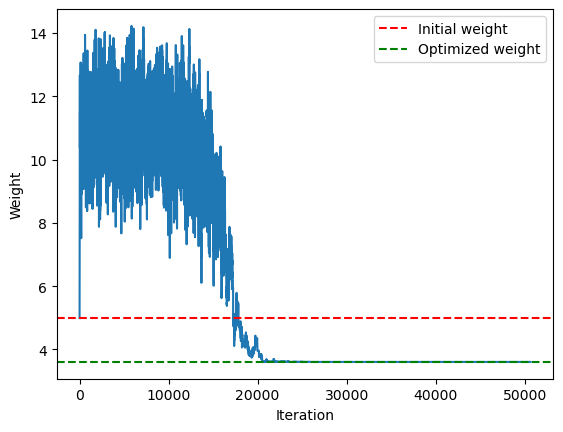

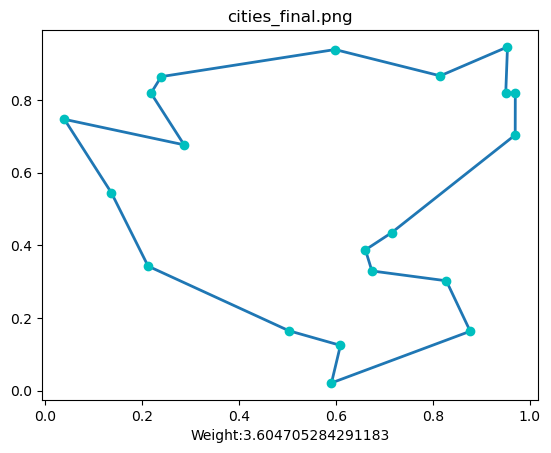

In [34]:
    '''set the simulated annealing algorithm params'''
    #test run based on wrong points
temp = 1000
ST = 0.00000001
gamma = 0.9995
SI = 10000000
xs = [0.6606,0.9695,0.5906, 0.2124, 0.0398, 0.1367,0.9536,0.6091,0.8767,0.8148,0.9500,0.6740,0.5029,0.8274,0.9697,0.5979,0.2184,0.7148,0.2395,0.2867]
ys = [0.3876,0.7041,0.0213,0.3429,0.7471,0.5449,0.9464,0.1247,0.1636,0.8668,0.8200,0.3296,0.1649,0.3025,0.8192,0.9392,0.8191,0.4351,0.8646,0.6768]
#print(f"X: {d} && Y:{s}",len(xs),len(ys))
nodes = np.column_stack((xs, ys))
run(nodes,SI, temp, gamma, ST)

Intial weight:  5.22894797811956
Minimum weight:  4.03611113354273
Improvement:  22.81 %
Intial weight:  5.452254618497038
Minimum weight:  4.030656182592688
Improvement:  26.07 %
Intial weight:  4.887909931685917
Minimum weight:  4.03065618259269
Improvement:  17.54 %
Intial weight:  5.3312003295476975
Minimum weight:  4.054910629557462
Improvement:  23.94 %
Intial weight:  4.908185133302875
Minimum weight:  4.03611113354273
Improvement:  17.77 %
Intial weight:  4.444147300922404
Minimum weight:  4.036111133542731
Improvement:  9.180000000000001 %
Intial weight:  5.4142170956833695
Minimum weight:  4.076046089443103
Improvement:  24.72 %
Intial weight:  5.320873149675946
Minimum weight:  4.030656182592688
Improvement:  24.25 %
Intial weight:  4.502090428504454
Minimum weight:  4.076046089443103
Improvement:  9.46 %
Intial weight:  4.887909931685917
Minimum weight:  4.030656182592688
Improvement:  17.54 %
Intial weight:  5.014274936724524
Minimum weight:  4.076046089443103
Improvement:

<function matplotlib.pyplot.show(close=None, block=None)>

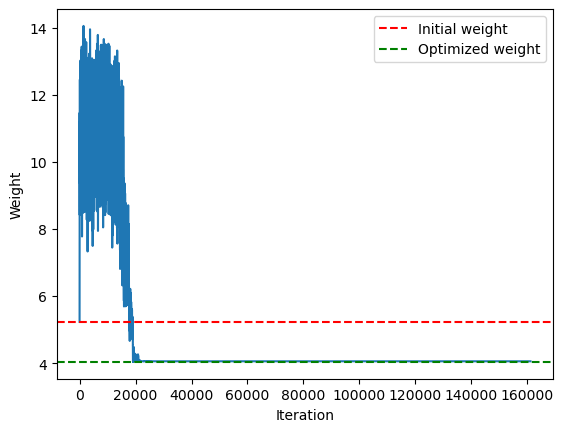

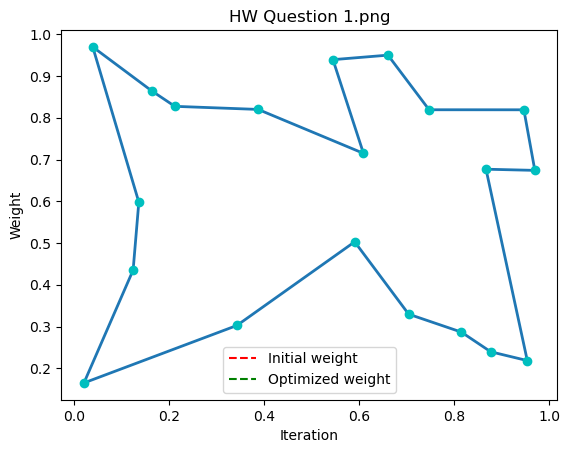

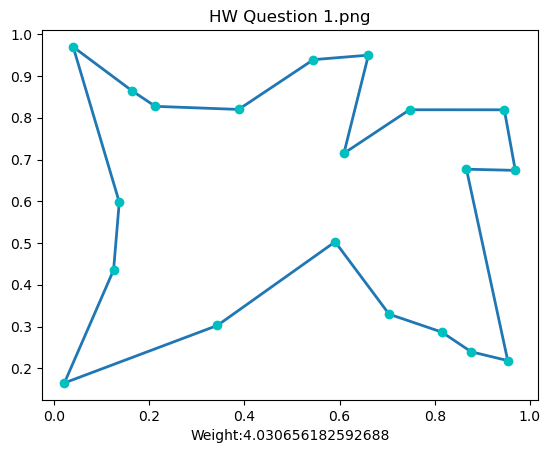

In [35]:
#actia run
temp = 1000
ST = 0.00000000000000000000000000000001
gamma = 0.9995
SI = 10000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000
xs = [0.6606,0.9695,0.5906, 0.2124, 0.0398, 0.1367,0.9536,0.6091,0.8767,0.8148,0.3876,0.7041,0.0213,0.3429,0.7471,0.5449,0.9464,0.1247,0.1636,0.8668]
ys = [0.9500,0.6740,0.5029,0.8274,0.9697,0.5979,0.2184,0.7148,0.2395,0.2867,0.8200,0.3296,0.1649,0.3025,0.8192,0.9392,0.8191,0.4351,0.8646,0.6768]
#print(f"X: {d} && Y:{s}",len(xs),len(ys))
nodes = np.column_stack((xs, ys))
name="HW Question 1.png"
weight = np.inf
#for loop that run through the map 20 times to get the attempt the best solution 
for i in range(0,20):
    weight = run(nodes,SI, temp, gamma, ST,name, weight)


plt.show

In [36]:
#data for the 101 cities
data = [1, 41, 49, 2, 35, 17, 3, 55, 45, 4, 55, 20, 5, 15, 30, 6, 25, 30, 7, 20, 50, 8, 10, 43, 9, 55, 60, 10, 30, 60, 11, 20, 65, 12, 50, 35, 13, 30, 25, 14, 15, 10, 15, 30, 5, 16, 10, 20, 17, 5, 30, 18, 20, 40, 19, 15, 60, 20, 45, 65, 21, 45, 20, 22, 45, 10, 23, 55, 5, 24, 65, 35, 25, 65, 20, 26, 45, 30, 27, 35, 40, 28, 41, 37, 29, 64, 42, 30, 40, 60, 31, 31, 52, 32, 35, 69, 33, 53, 52, 34, 65, 55, 35, 63, 65, 36, 2, 60, 37, 20, 20, 38, 5, 5, 39, 60, 12, 40, 40, 25, 41, 42, 7, 42, 24, 12, 43, 23, 3, 44, 11, 14, 45, 6, 38, 46, 2, 48, 47, 8, 56, 48, 13, 52, 49, 6, 68, 50, 47, 47, 51, 49, 58, 52, 27, 43, 53, 37, 31, 54, 57, 29, 55, 63, 23, 56, 53, 12, 57, 32, 12, 58, 36, 26, 59, 21, 24, 60, 17, 34, 61, 12, 24, 62, 24, 58, 63, 27, 69, 64, 15, 77, 65, 62, 77, 66, 49, 73, 67, 67, 5, 68, 56, 39, 69, 37, 47, 70, 37, 56, 71, 57, 68, 72, 47, 16, 73, 44, 17, 74, 46, 13, 75, 49, 11, 76, 49, 42, 77, 53, 43, 78, 61, 52, 79, 57, 48, 80, 56, 37, 81, 55, 54, 82, 15, 47, 83, 14, 37, 84, 11, 31, 85, 16, 22, 86, 4, 18, 87, 28, 18, 88, 26, 52, 89, 26, 35, 90, 31, 67, 91, 15, 19, 92, 22, 22, 93, 18, 24, 94, 26, 27, 95, 25, 24, 96, 22, 27, 97, 25, 21, 98, 19, 21, 99, 20, 26, 100, 18, 18, 101, 35, 35]

Intial weight:  917.3607787145356
Minimum weight:  679.431646862608
Improvement:  25.94 %
Intial weight:  797.5384960420745
Minimum weight:  688.3870626309741
Improvement:  13.69 %
Intial weight:  760.4925294157683
Minimum weight:  683.7849513279084
Improvement:  10.09 %
Intial weight:  802.316665764872
Minimum weight:  684.6114797612308
Improvement:  14.67 %
Intial weight:  822.3436318636275
Minimum weight:  709.6246474592393
Improvement:  13.71 %
Intial weight:  802.316665764872
Minimum weight:  677.0768670646064
Improvement:  15.61 %
Intial weight:  815.4958442450514
Minimum weight:  707.7225228445939
Improvement:  13.22 %
Intial weight:  804.4300190183241
Minimum weight:  693.8663707478393
Improvement:  13.74 %
Intial weight:  784.4082875651105
Minimum weight:  696.3422224380356
Improvement:  11.23 %
Intial weight:  762.0344161580787
Minimum weight:  702.0183927956032
Improvement:  7.88 %
Intial weight:  825.2423227277445
Minimum weight:  711.5065589505963
Improvement:  13.78000000

<function matplotlib.pyplot.show(close=None, block=None)>

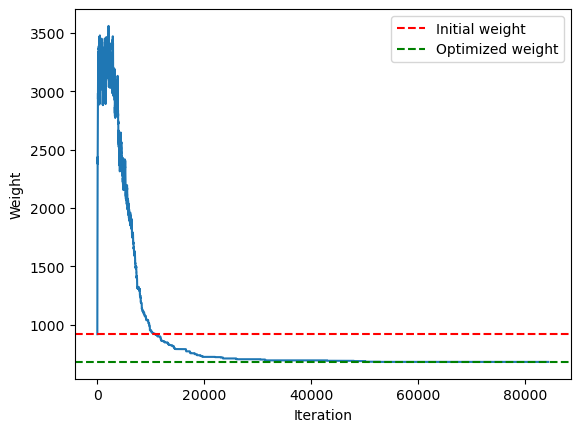

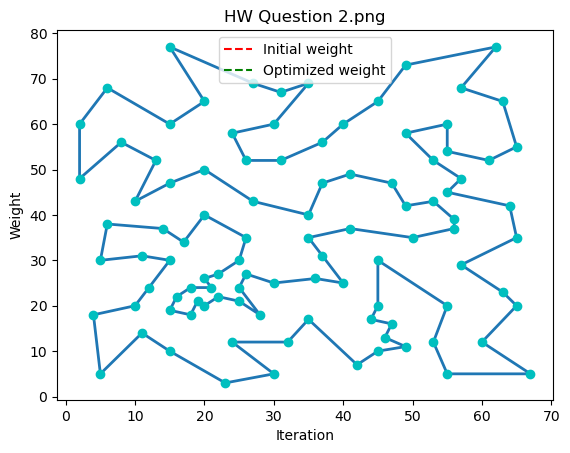

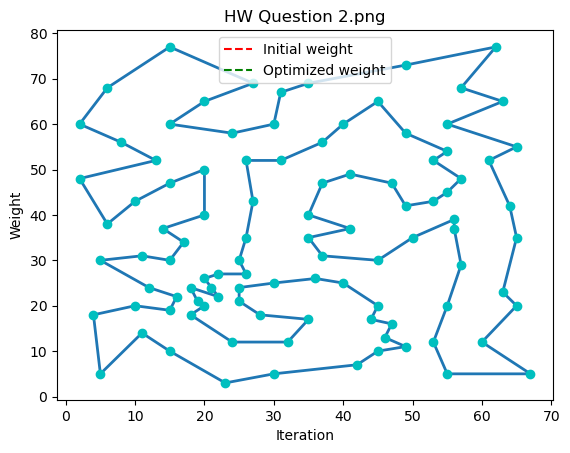

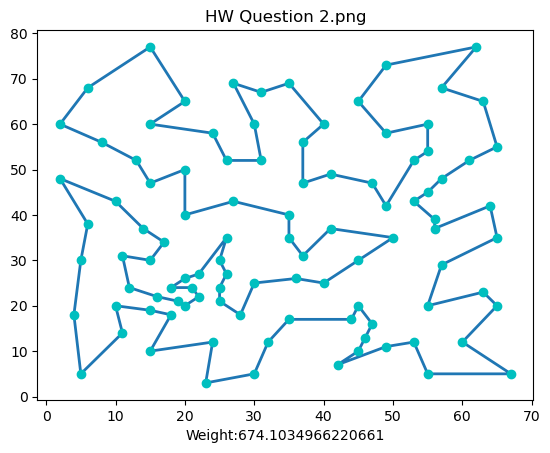

In [37]:
#take every third data value for the number of each city
value = data[::3]
#pop off the first value
data.pop(0)
#get all the x valeus for the cities
xs = data[::3]
#pop again
data.pop(0)
#get all the y values
ys = data[::3]





#settings
temp = 200
ST = 0.0000000000000001
gamma = 0.9995
SI = 100000000000000000000000000000000000000000
#make array with x and y
nodes = np.column_stack((xs, ys))
#name the saved graph
name="HW Question 2.png"

weight = np.inf
#run 30 times
for i in range(0,30):
    #feedback the returned weight
    weight = run(nodes,SI, temp, gamma, ST,name, weight)


plt.show
#idk why the charts for this one mess up 

Intial weight:  777.5354236923063
Minimum weight:  712.4791446488949
Improvement:  8.37 %
Intial weight:  746.3851974073968
Minimum weight:  727.6808279834778
Improvement:  2.5100000000000002 %
Intial weight:  782.4834394011774
Minimum weight:  716.8910132161026
Improvement:  8.38 %
Intial weight:  794.4966192979791
Minimum weight:  699.5221381165946
Improvement:  11.95 %
Intial weight:  822.3436318636275
Minimum weight:  699.5609279020398
Improvement:  14.93 %
Intial weight:  808.4168515667888
Minimum weight:  706.3483043962442
Improvement:  12.629999999999999 %
Intial weight:  816.4511558169809
Minimum weight:  699.1898238329974
Improvement:  14.360000000000001 %
Intial weight:  764.0519266948331
Minimum weight:  697.9528604595779
Improvement:  8.649999999999999 %
Intial weight:  819.8967849681342
Minimum weight:  690.8287824374969
Improvement:  15.740000000000002 %
Intial weight:  828.3152127854873
Minimum weight:  709.9918226652239
Improvement:  14.280000000000001 %
Intial weight: 

<function matplotlib.pyplot.show(close=None, block=None)>

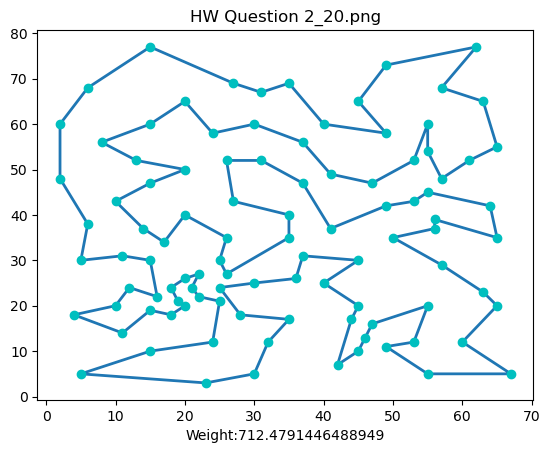

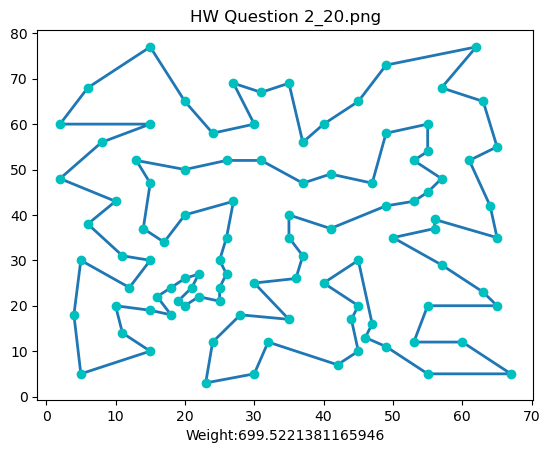

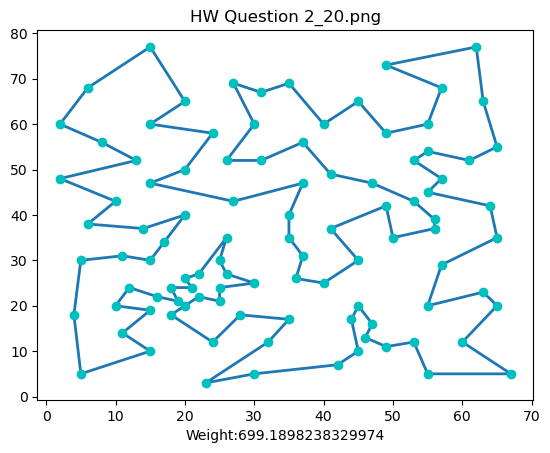

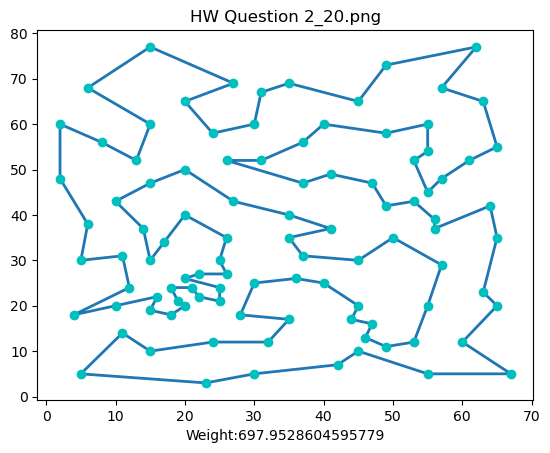

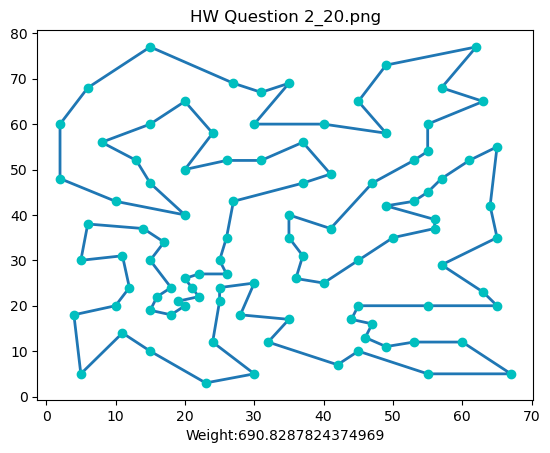

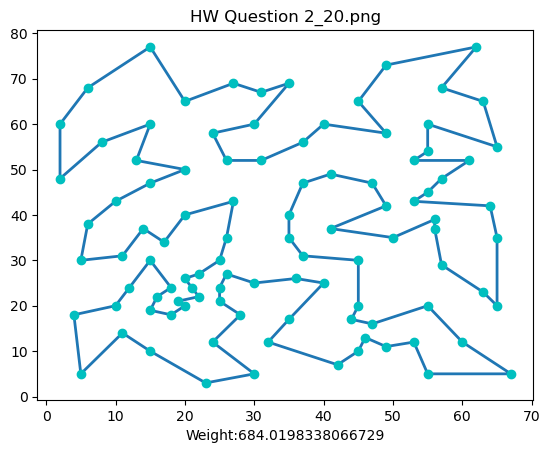

In [38]:
name="HW Question 2_20.png"
temp = 20
weight = np.inf
for i in range(0,30):
    #feedback the returned weight
    weight = run(nodes,SI, temp, gamma, ST,name, weight,False)


plt.show

Intial weight:  748.8847705214857
Minimum weight:  672.4009723676072
Improvement:  10.209999999999999 %
Intial weight:  792.4349408780516
Minimum weight:  694.1883224534712
Improvement:  12.4 %
Intial weight:  794.4966192979794
Minimum weight:  679.4805347754763
Improvement:  14.48 %
Intial weight:  746.36064315413
Minimum weight:  702.7892688293738
Improvement:  5.84 %
Intial weight:  769.0484257388638
Minimum weight:  674.9962612762156
Improvement:  12.23 %
Intial weight:  784.4082875651105
Minimum weight:  689.3846630629761
Improvement:  12.11 %
Intial weight:  748.8847705214857
Minimum weight:  675.676823668322
Improvement:  9.78 %
Intial weight:  763.9059427825997
Minimum weight:  674.0395624564501
Improvement:  11.76 %
Intial weight:  799.5805279304747
Minimum weight:  677.5740681072199
Improvement:  15.260000000000002 %
Intial weight:  746.3851974073968
Minimum weight:  682.2726567053154
Improvement:  8.59 %
Intial weight:  800.1415656713435
Minimum weight:  684.2962033803723
Im

<function matplotlib.pyplot.show(close=None, block=None)>

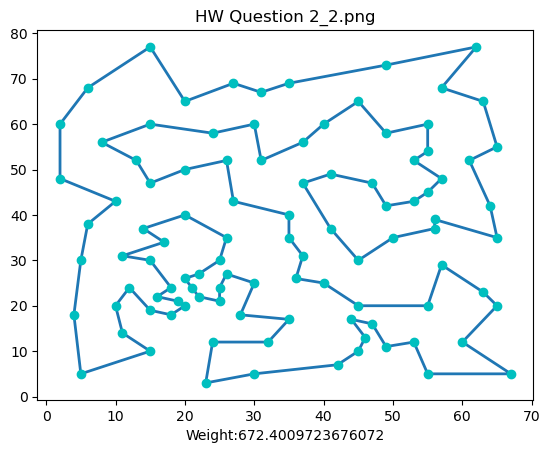

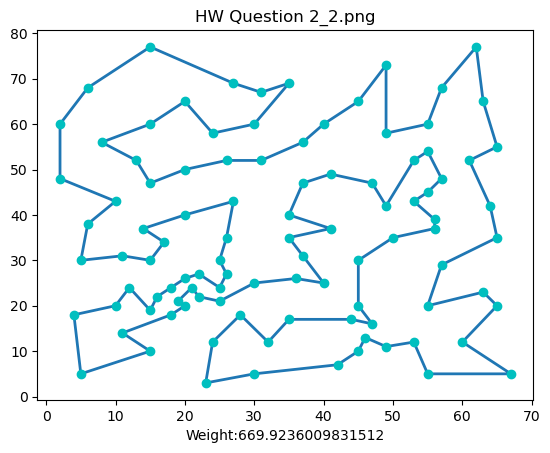

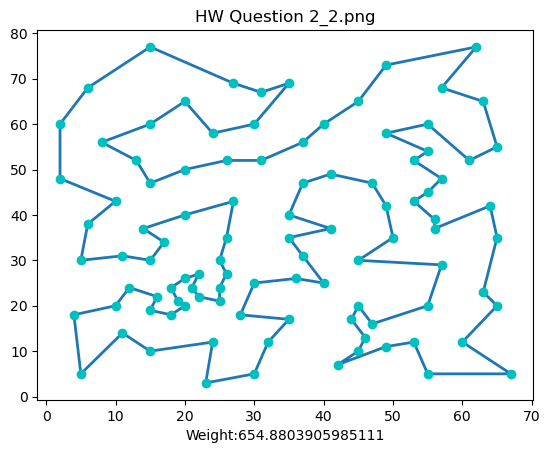

In [39]:
name="HW Question 2_2.png"
temp = 2
weight = np.inf
for i in range(0,30):
    #feedback the returned weight
    weight = run(nodes,SI, temp, gamma, ST,name, weight,False)


plt.show

Intial weight:  778.8159377103368
Minimum weight:  692.2080199876513
Improvement:  11.12 %
Intial weight:  763.9059427825997
Minimum weight:  694.674130958978
Improvement:  9.06 %
Intial weight:  780.4502458301872
Minimum weight:  704.7007243644259
Improvement:  9.71 %
Intial weight:  819.5979989877326
Minimum weight:  703.5841574616651
Improvement:  14.149999999999999 %
Intial weight:  777.5354236923063
Minimum weight:  694.9991164396889
Improvement:  10.620000000000001 %
Intial weight:  821.6661310838604
Minimum weight:  691.6256870001804
Improvement:  15.83 %
Intial weight:  746.3851974073968
Minimum weight:  705.6985956008679
Improvement:  5.45 %
Intial weight:  794.8608537531998
Minimum weight:  696.5104585039677
Improvement:  12.370000000000001 %
Intial weight:  746.36064315413
Minimum weight:  695.5013888619316
Improvement:  6.81 %
Intial weight:  819.8967849681342
Minimum weight:  690.5800095332264
Improvement:  15.770000000000001 %
Intial weight:  763.9059427825997
Minimum wei

<function matplotlib.pyplot.show(close=None, block=None)>

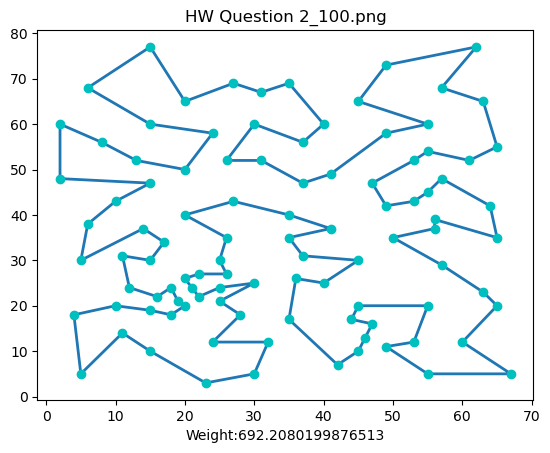

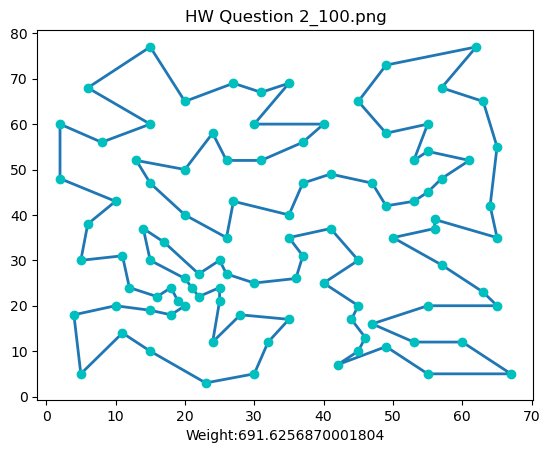

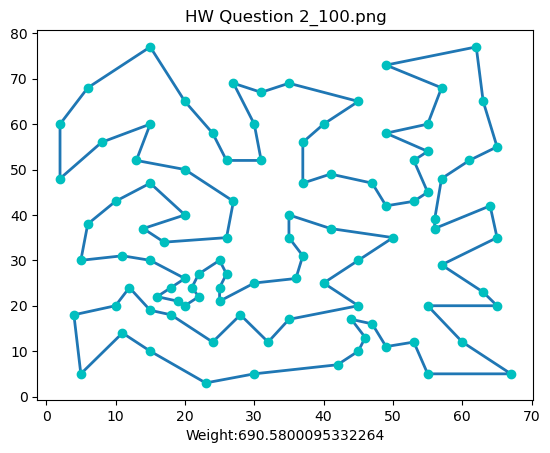

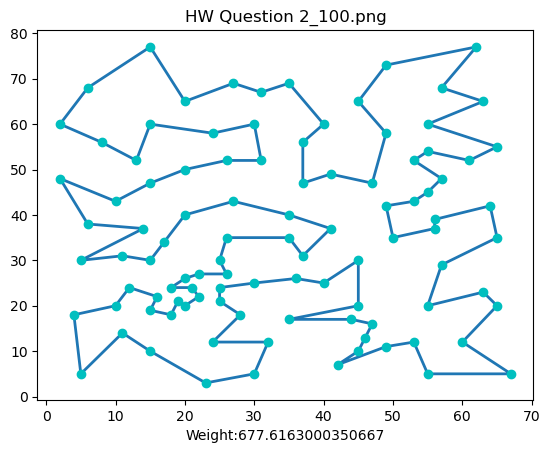

In [40]:
name="HW Question 2_100.png"
temp = 100
weight = np.inf
for i in range(0,30):
    #feedback the returned weight
    weight = run(nodes,SI, temp, gamma, ST,name, weight,False)


plt.show

Intial weight:  780.4502458301872
Minimum weight:  691.3798179405138
Improvement:  11.41 %
Intial weight:  750.4765472446395
Minimum weight:  690.7789958250762
Improvement:  7.95 %
Intial weight:  746.36064315413
Minimum weight:  687.5261223920373
Improvement:  7.88 %
Intial weight:  782.6269886669787
Minimum weight:  710.4223026044519
Improvement:  9.229999999999999 %
Intial weight:  769.0392369904995
Minimum weight:  688.5745045437131
Improvement:  10.459999999999999 %
Intial weight:  803.2533985604902
Minimum weight:  707.7915945457762
Improvement:  11.88 %
Intial weight:  819.5979989877326
Minimum weight:  706.8279334015226
Improvement:  13.76 %
Intial weight:  799.5805279304747
Minimum weight:  700.8608574984421
Improvement:  12.35 %
Intial weight:  746.3851974073968
Minimum weight:  674.1804661671636
Improvement:  9.67 %
Intial weight:  788.5719021555468
Minimum weight:  715.0000265683624
Improvement:  9.33 %
Intial weight:  804.3602132786455
Minimum weight:  686.4757530656741
Im

/tmp/ipykernel_390799/898946657.py:138: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Minimum weight:  687.7105606672876
Improvement:  13.77 %
Intial weight:  800.1415656713435
Minimum weight:  694.6236795983029
Improvement:  13.19 %
Intial weight:  806.2540485820623
Minimum weight:  691.3953315167463
Improvement:  14.249999999999998 %
Intial weight:  917.3607787145356
Minimum weight:  710.5010841696077
Improvement:  22.55 %
Intial weight:  796.0413972056176
Minimum weight:  710.3027790270692
Improvement:  10.77 %
Intial weight:  894.6314404293532
Minimum weight:  688.38376600549
Improvement:  23.05 %
Intial weight:  811.5593135612681
Minimum weight:  688.286426414291
Improvement:  15.190000000000001 %
Intial weight:  918.5468208411437
Minimum weight:  723.0967794992324
Improvement:  21.279999999999998 %
Intial weight:  917.3607787145356
Minimum weight:  681.3783537514802
Improvement:  25.72 %
Intial weight:  806.2540485820623
Minimum weight:  700.229345654109
Improvement:  13.15 %
Intial weight:  785.9871442319646
Minimum weight:  697.8562173495131
Improvement:  11.21 

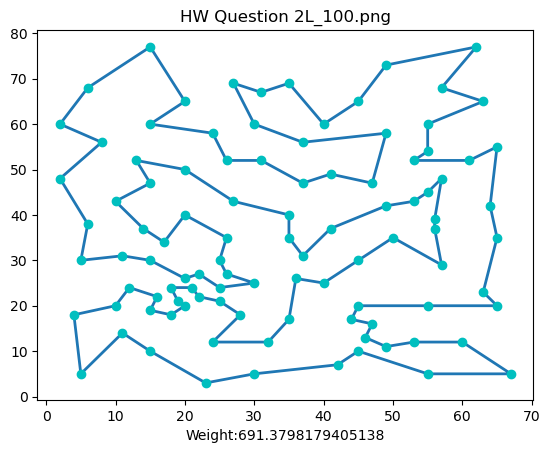

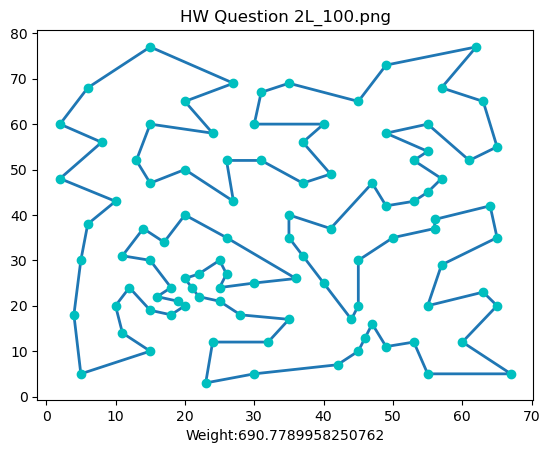

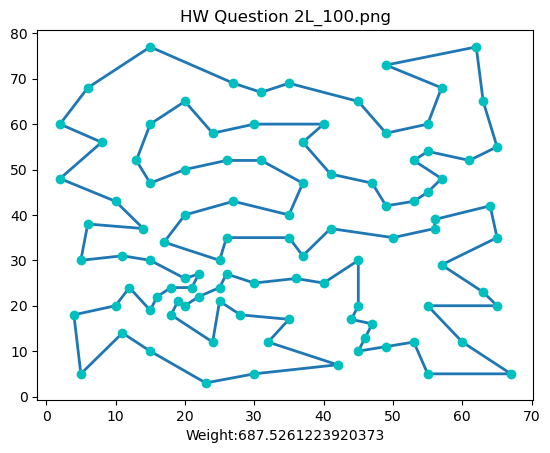

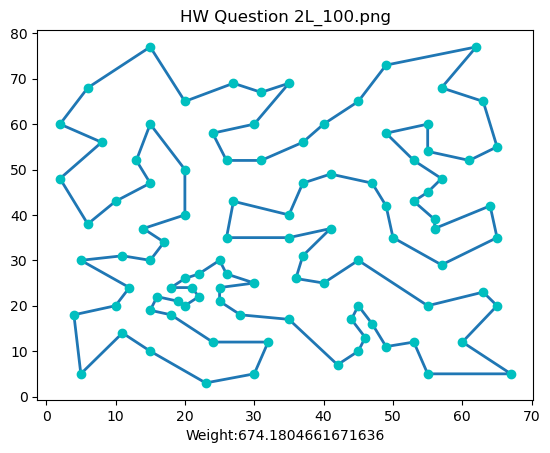

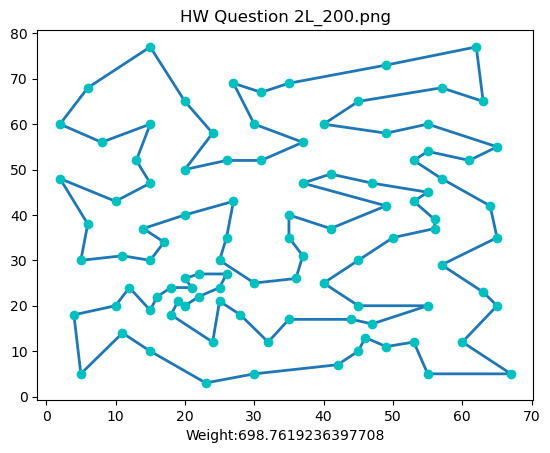

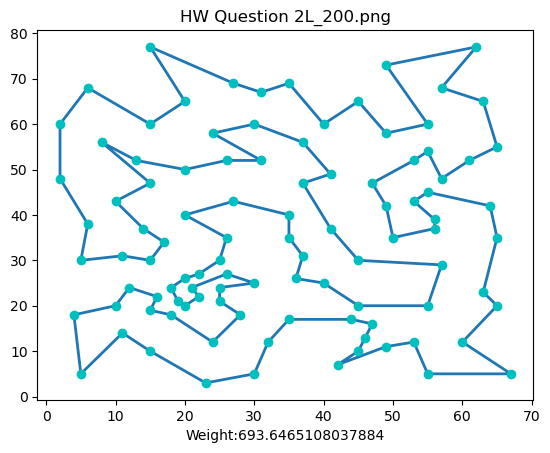

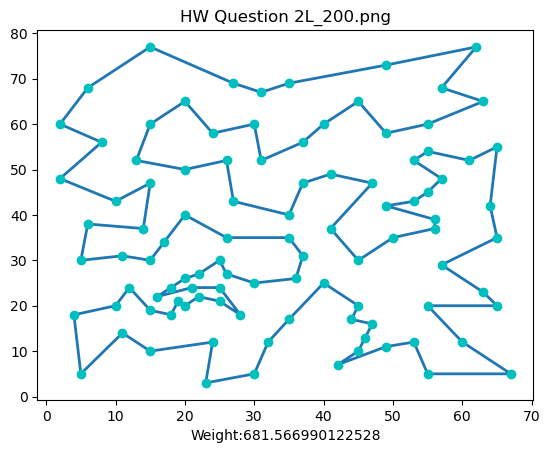

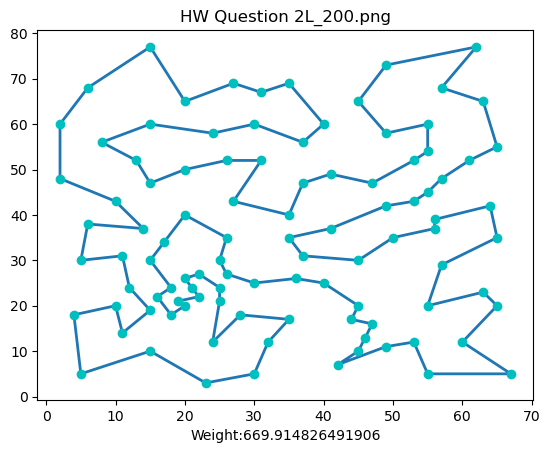

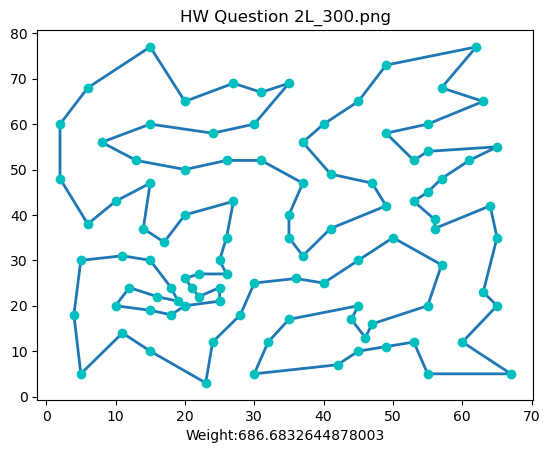

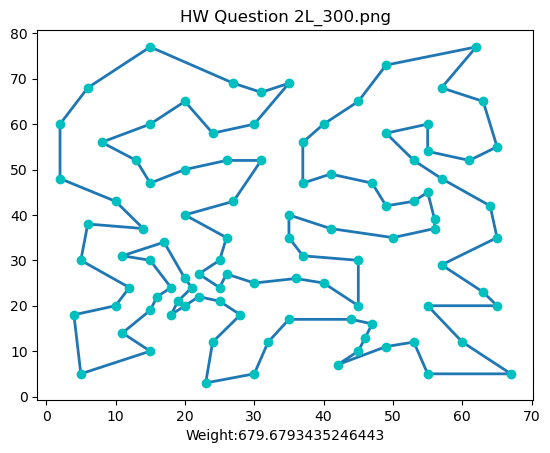

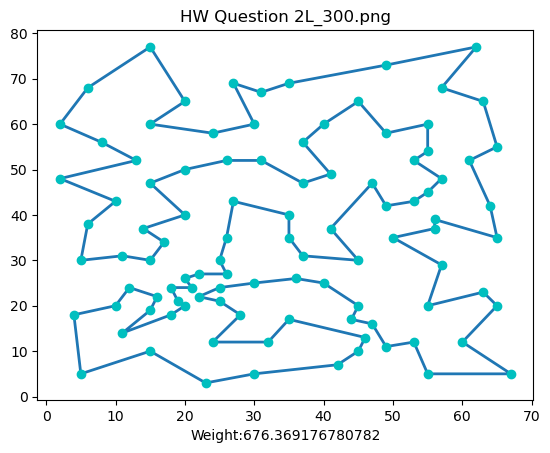

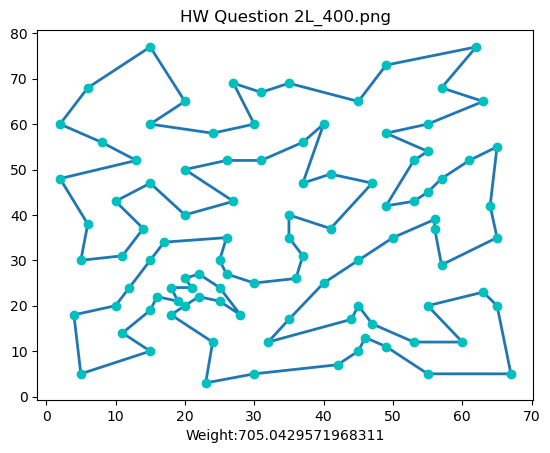

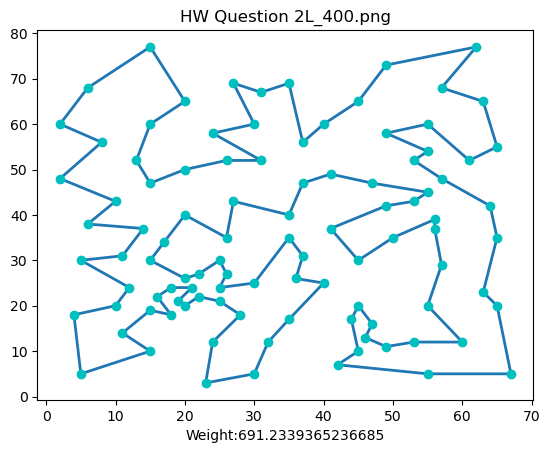

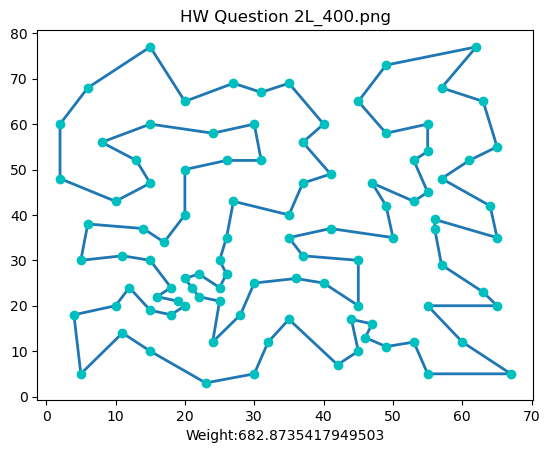

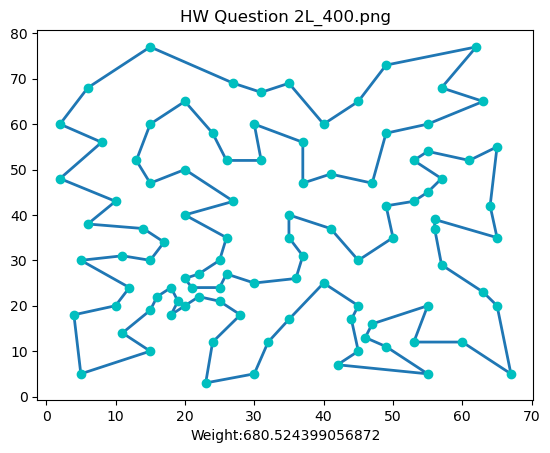

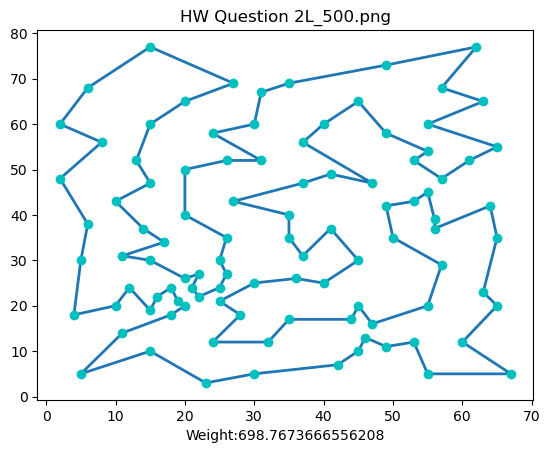

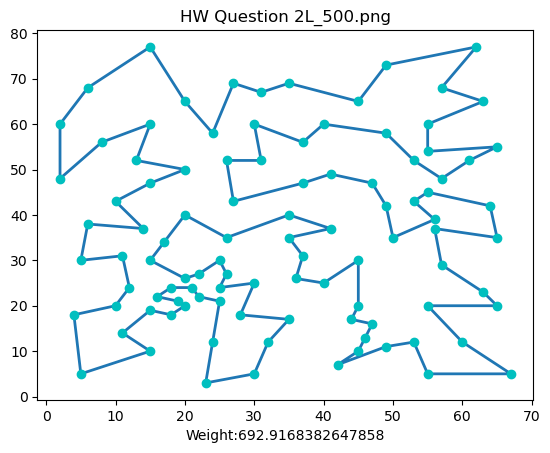

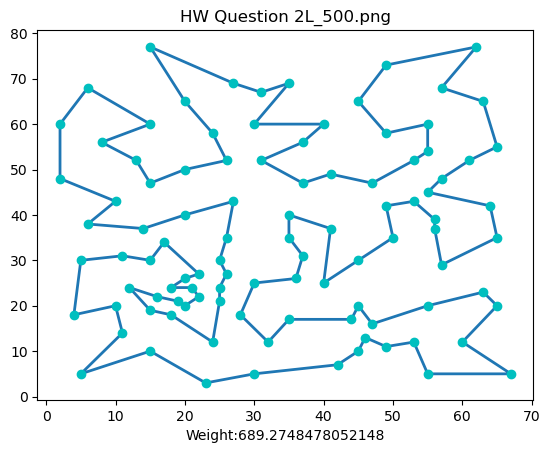

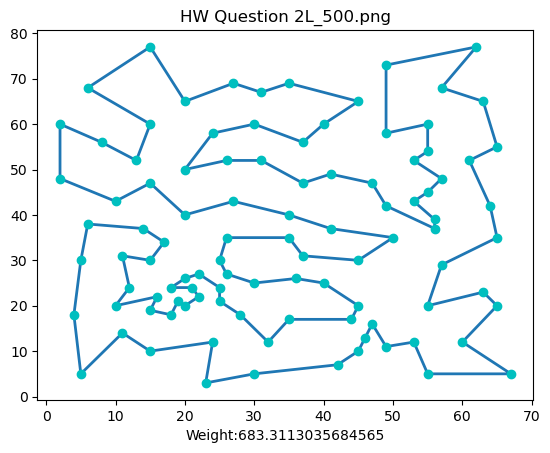

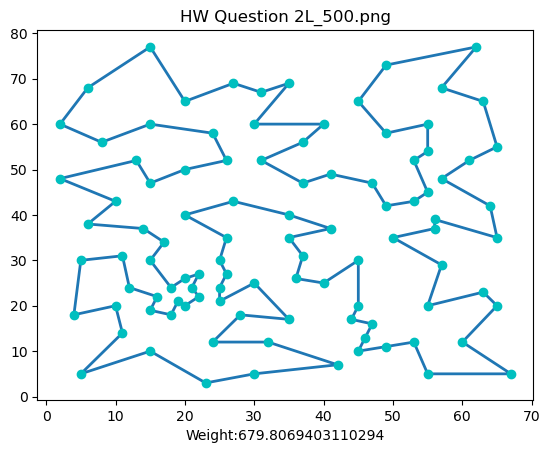

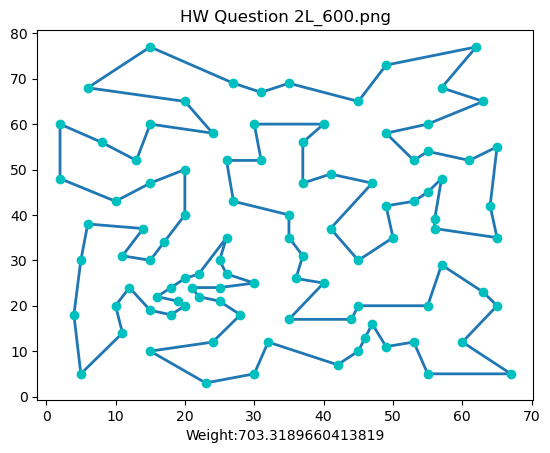

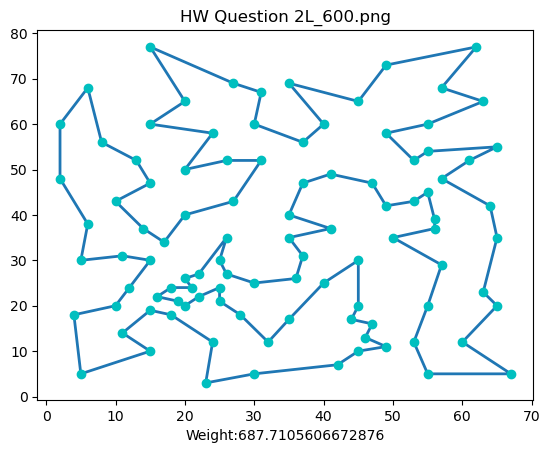

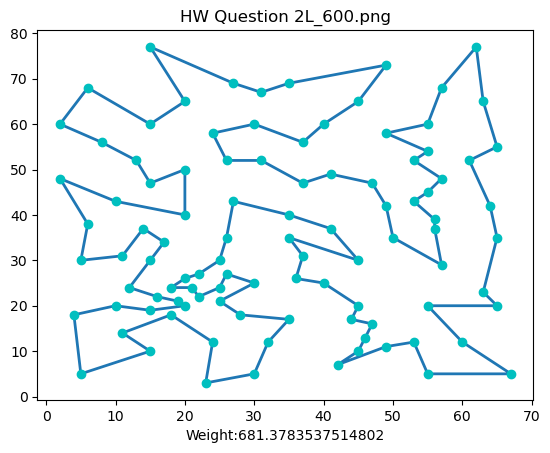

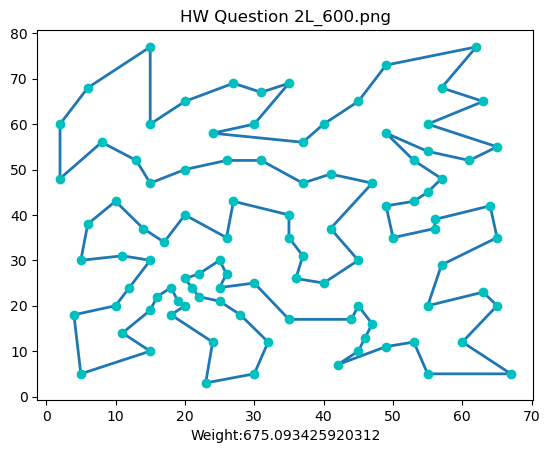

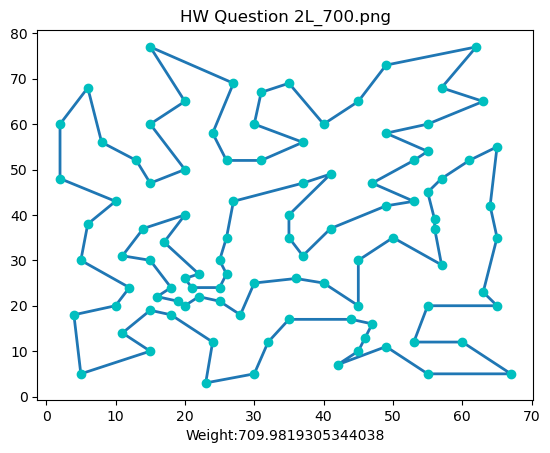

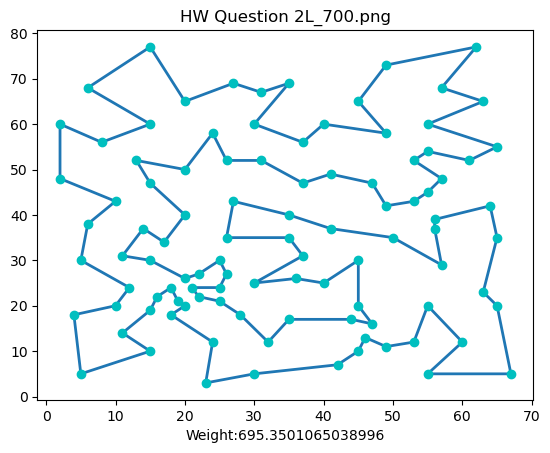

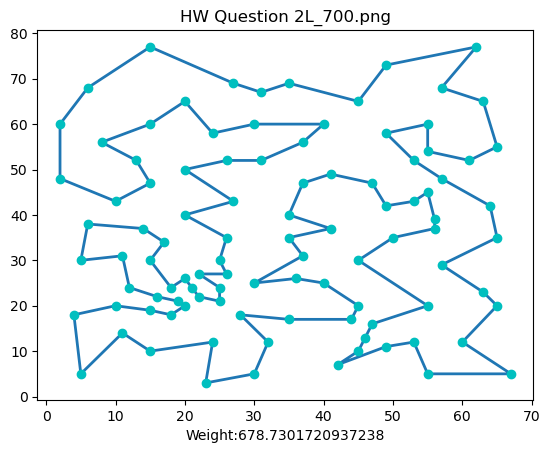

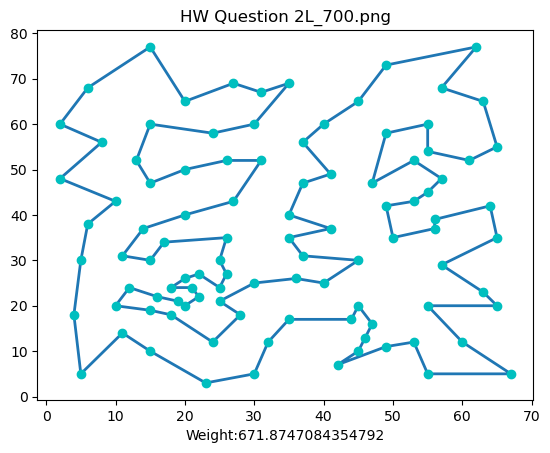

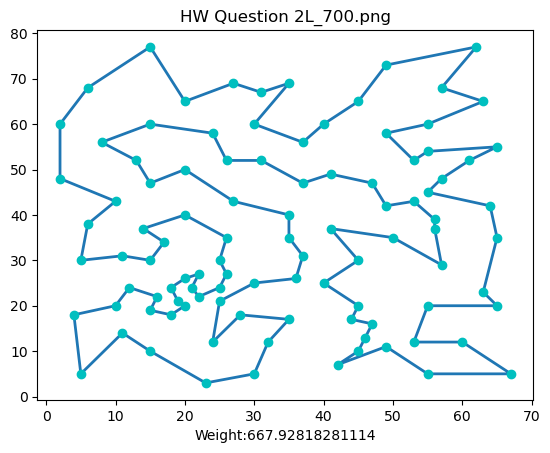

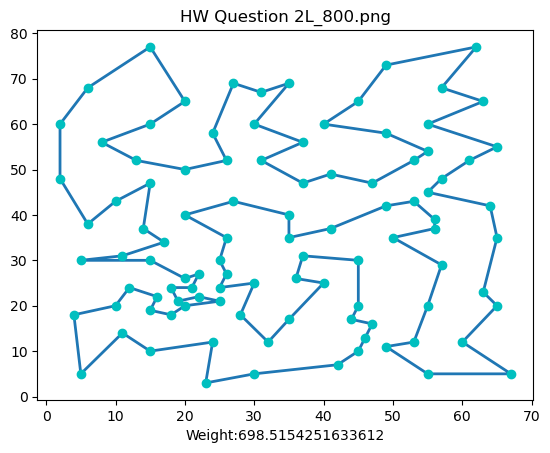

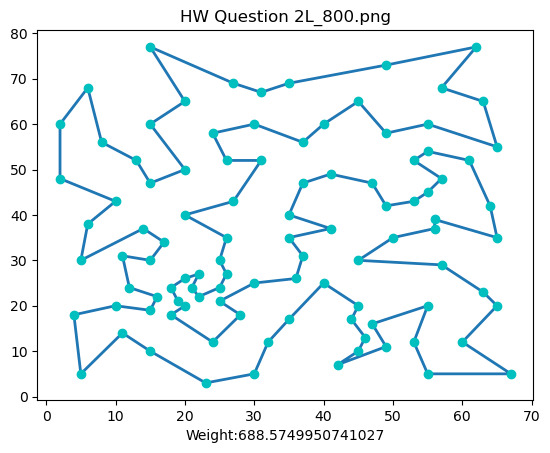

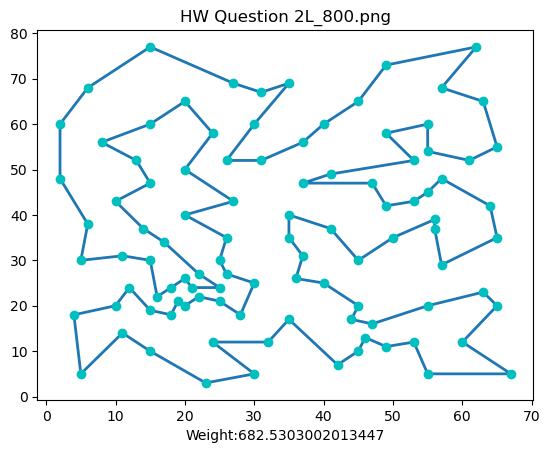

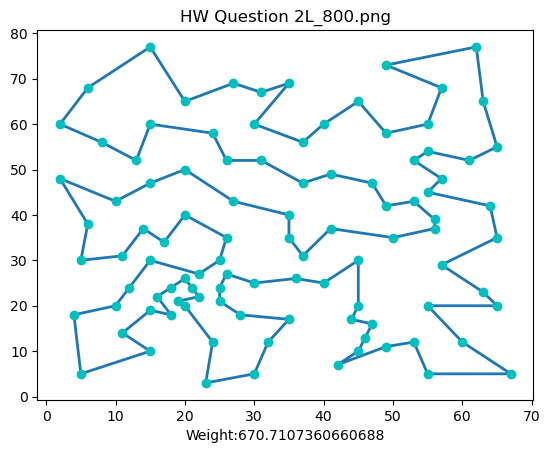

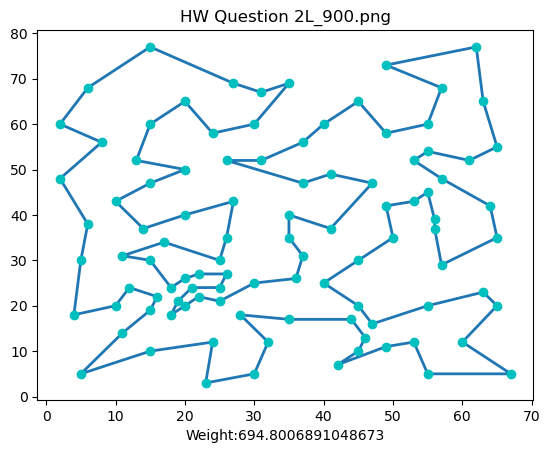

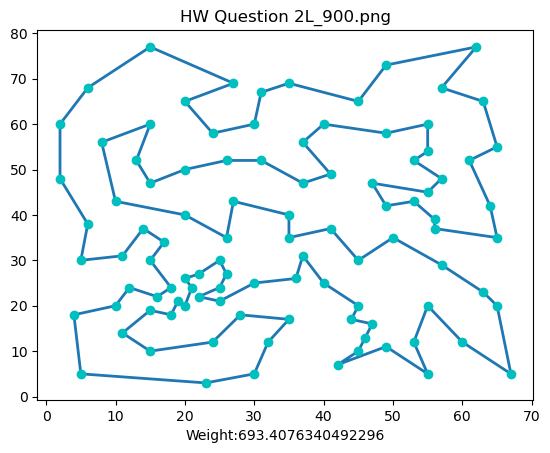

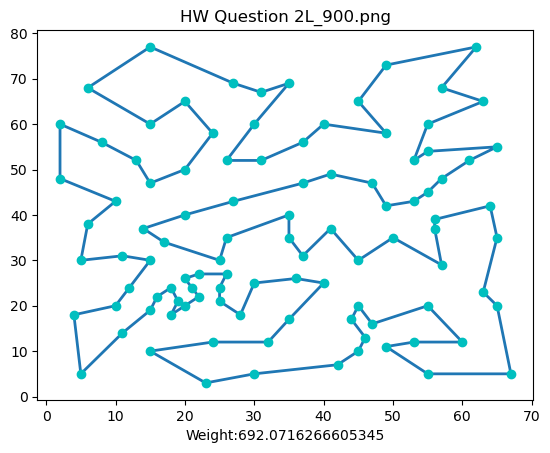

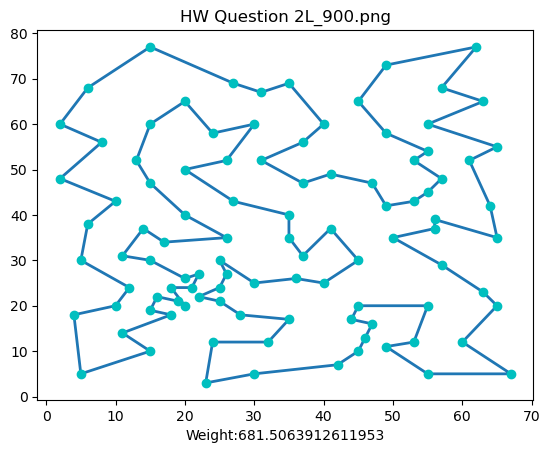

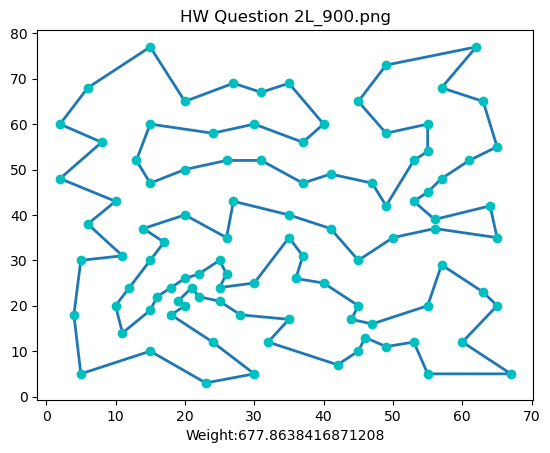

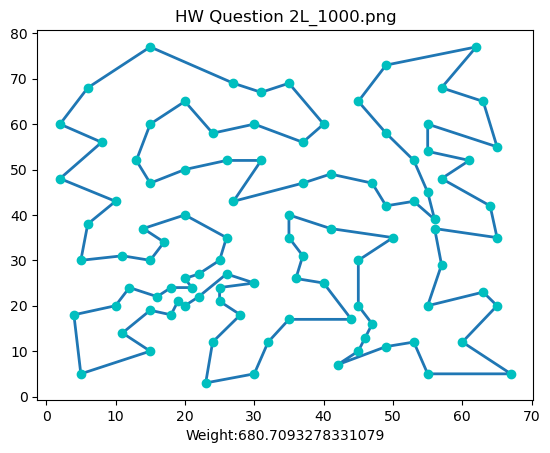

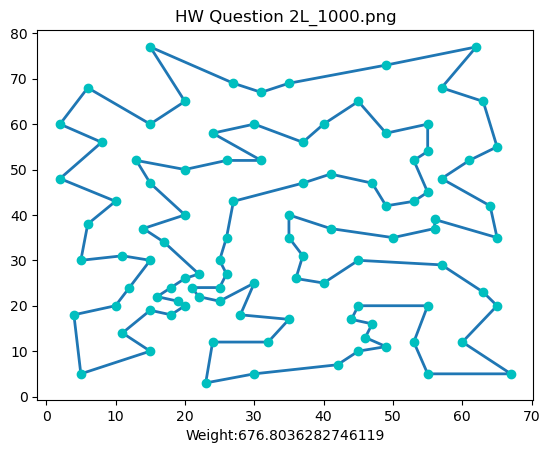

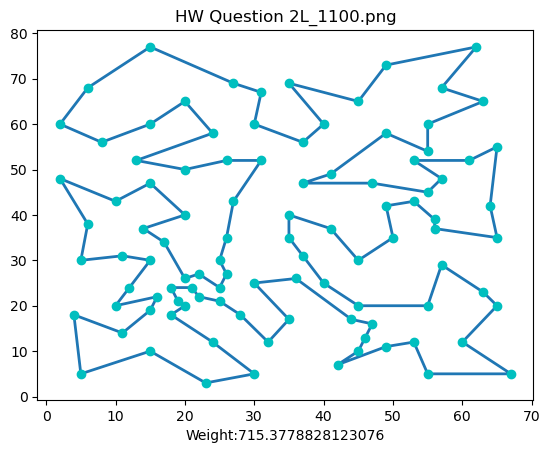

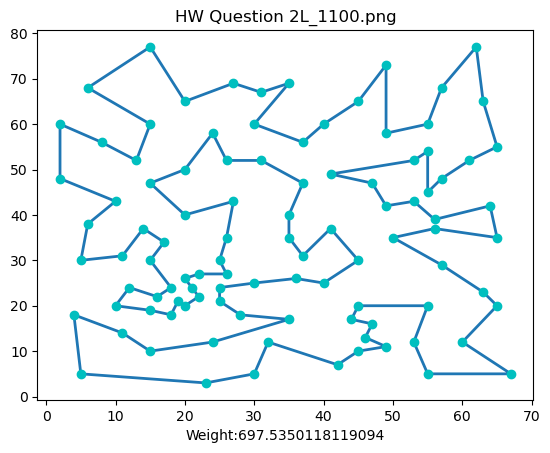

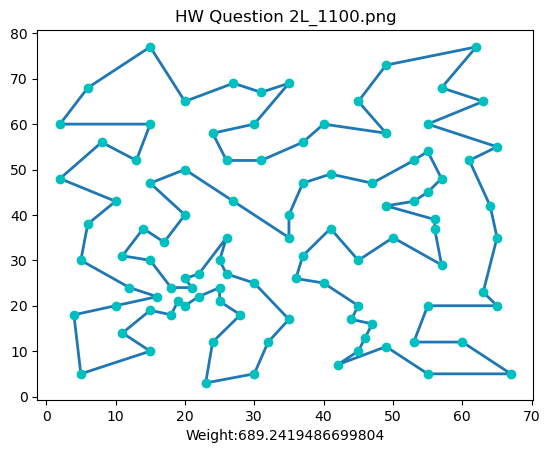

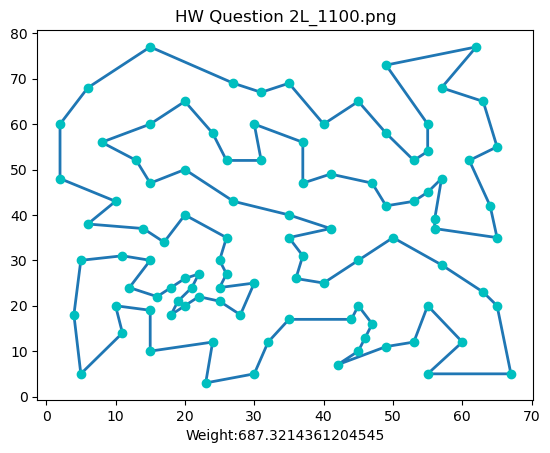

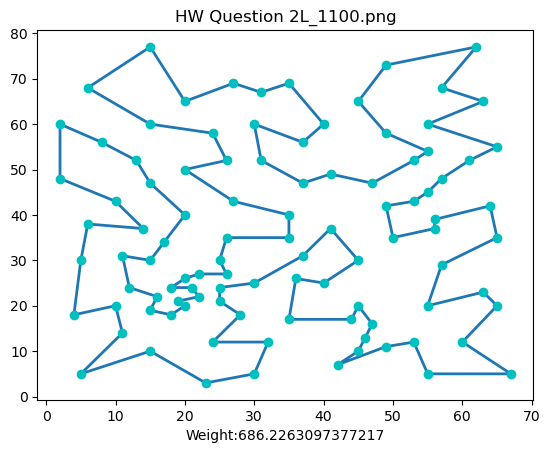

In [41]:
temp = 100

while temp <= 1100:
    name="HW Question 2L_"+str(temp)+".png"
    weight = np.inf
    for i in range(0,30):
        #feedback the returned weight
        weight = run(nodes,SI, temp, gamma, ST,name, weight,False)
    temp = temp+100
    plt.show


